## TODO  
モザイク画像のセグメンテーションも一度パッチに分解したものをあとで結合するようにしよう  
多クラス同時セグメンテーションをやったあと，One-hotセグメンテーションはどうなるのかやってみよう

## Image Preparation

Generating patches from mosaics.  
  
imagePatcherSemSeg.py is refered to make preparation program below.  

imagePatcherSemSeg.py is used for deviding a mosaic image and GT segmentation images into the patches like this.  
``` 
$ python imagePatcherSemSeg.py ./datasets/wM1 500 ./results/ wM
```
Here, 500 is the length of a side of a patch.  
  
To gain the number of patches, 
- Rotated patches (90, 180 and 270 degree) are also generated for each patches
- Scale shifted patches (1000, 1000) is generated and resized into same size (500, 500)

In [1]:
import cv2, numpy as np

Parameters

In [37]:
VERBOSE = True
LAYER_NAMES =  ["nothing",     "river",     "decidious", "uncovered", "evergreen", "manmade" ]
LAYER_COLORS = [(255,255,255), (64,128,64), (192,0,128), (0,128,192), (128,0,0),   (64,0,128)]
LAYER_LEN = len(LAYER_COLORS)
# MOSAIC_NAMES = ["wM1", "wM2", "wM3", "wM4", "wM5", "wM6", "wM7"]
MOSAIC_NAMES = ["wM1"]
# PATCH_SIZES = [640, 1280, 2560]
PATCH_SIZES = [640]
ROTATE = False

RESIZE_TO = 640 # needs to be multiple of 640 for the u-net. why? somehow it outputs 496*496 predictions
EMPTY_THRESHOLD = 50
INDEX_DIGITS = 5

DATASET_DIR = "../datasets/forests/"
OUTPUT_DIR = DATASET_DIR + "patches/"
SEGM_DIR = OUTPUT_DIR + "segmentation/"
MOSAIC_DIR = OUTPUT_DIR + "mosaic/"
SEGM_VEC_DIR = OUTPUT_DIR + "segmentation_vector/"

Reading layer images

In [40]:
layers = [[] for i in range(len(MOSAIC_NAMES))]

for mosaic_id, name in enumerate(MOSAIC_NAMES):
    for layer_id in range(LAYER_LEN):
        layer_file_name = f"{DATASET_DIR}{name}layer{layer_id}.jpg"
        layer = cv2.imread(layer_file_name, cv2.IMREAD_GRAYSCALE)

        if layer is not None:
            if VERBOSE: print(f"Get layer image: {layer_file_name}")
            layers[mosaic_id].append(layer)

Get layer image: ../datasets/forests/wM1layer0.jpg
Get layer image: ../datasets/forests/wM1layer1.jpg
Get layer image: ../datasets/forests/wM1layer2.jpg
Get layer image: ../datasets/forests/wM1layer3.jpg
Get layer image: ../datasets/forests/wM1layer4.jpg


Generating patches  
Empty patches are skipped

In [46]:
def crop_square(image, left, top, size):
    return image[ left : left + size, top : top + size]

def resize(image):
    return cv2.resize(image, (RESIZE_TO, RESIZE_TO))

patch_count = 0

for m, name in enumerate(MOSAIC_NAMES):

    mosaic = cv2.imread(f"{DATASET_DIR}{name}.jpg")
    size_x, size_y, _ = mosaic.shape
    
    if VERBOSE: print(f"Create patches for {DATASET_DIR}{name}.jpg")
    
    for patch_size in PATCH_SIZES:

        image_is_empty = lambda image: \
            np.sum(image == 0) <= int(EMPTY_THRESHOLD * (patch_size / RESIZE_TO))

        crop_patch = lambda image, i, j: \
            crop_square(image, i * patch_size, j * patch_size, patch_size)

        step_x, step_y = np.array([size_x, size_y]) // patch_size

        for i in range(step_x):
            for j in range(step_y):

                segm_patch = np.full((patch_size, patch_size, 3), 255, dtype=np.uint8)
                segm_patch_vec = np.zeros((patch_size, patch_size, LAYER_LEN), dtype=np.float32)
                segm_patch_vec[:, :, 0] = 1
                
                # paint the empty patch by layer
                segm_patch_is_empty = True
                for layer_id, layer in enumerate(layers[m]):
                    layer_patch = crop_patch(layer, i, j)
                    if( image_is_empty(layer_patch) ): continue
                    segm_patch_is_empty = False
                    segm_patch[layer_patch == 0] = LAYER_COLORS[layer_id+1] # for nothing
                    segm_patch_vec[layer_patch == 0, layer_id+1] = 1.
                    segm_patch_vec[layer_patch == 0, 0] = 0

                # start saving the patches if any layers are not empty
                if(segm_patch_is_empty): continue

                # resize patches (for scale change)
                segm_patch = resize(segm_patch)
                segm_patch_vec = resize(segm_patch_vec)
                mosaic_patch = resize(crop_patch(mosaic, i, j))

                # rotate patches and save them
                for r in range(4 if ROTATE else 1):
                    index = str(patch_count).zfill(INDEX_DIGITS)
                    
                    segm_patch_name = f"{SEGM_DIR}{index}_{name}_{i}-{j}_{patch_size}_{r*90}_Segmentation.jpg"
                    cv2.imwrite(segm_patch_name, np.rot90(segm_patch, k=r))
                    
                    segm_patch_vec_name = f"{SEGM_VEC_DIR}{index}_{name}_{i}-{j}_{patch_size}_{r*90}_SegmentationVector"
                    np.save(segm_patch_vec_name, segm_patch_vec)

                    mosaic_patch_name = f"{MOSAIC_DIR}{index}_{name}_{i}-{j}_{patch_size}_{r*90}_Mosaic.jpg"
                    cv2.imwrite(mosaic_patch_name, np.rot90(mosaic_patch, k=r))

                    patch_count += 1

    if VERBOSE: print(f"{patch_count} patches are created so far")

Create patches for ../datasets/forests/wM1.jpg
201 patches are created so far


## Semantic Segmentation by U-net

In [52]:
import os, random, time, cv2, numpy as np
from tqdm import tqdm

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
from torch.autograd import Function, Variable

import matplotlib.pyplot as plt
%matplotlib inline

Parameters

In [53]:
RESULT_DIR = './results/'
CHECKPOINT_DIR =  RESULT_DIR + 'checkpoints/'
HISTORY_DIR = RESULT_DIR + 'histories/'

TEST_DATA_RATE = 0.05 # * all
VAL_DATA_RATE = 0.20 # * (all - test)

EPOCH = 5
BATCH_SIZE = 2
REPORT_INTERVAL = 10 # num of batch

Prepare patch names

In [54]:
mosaic_paths = [MOSAIC_DIR + file_name for file_name in sorted(os.listdir(MOSAIC_DIR))]
segm_paths = [SEGM_DIR + file_name for file_name in sorted(os.listdir(SEGM_DIR))]
segm_vec_paths = [SEGM_VEC_DIR + file_name for file_name in sorted(os.listdir(SEGM_VEC_DIR))]
all_pair_paths = list(zip(mosaic_paths, segm_paths, segm_vec_paths))
all_pair_len = len(all_pair_paths)

random.shuffle(all_pair_paths)

test_len = int(all_pair_len * TEST_DATA_RATE)
test_paths, non_test_paths = all_pair_paths[:test_len], all_pair_paths[test_len:]

val_len = int( (all_pair_len - test_len) * VAL_DATA_RATE )
train_len = all_pair_len - test_len - val_len
train_paths, val_paths = non_test_paths[:train_len], non_test_paths[train_len:]

print("All patch pairs:", all_pair_len)
print("for tests:", test_len)
print("for training:",  train_len)
print("for trainin validation:", val_len)

All patch pairs: 201
for tests: 10
for training: 153
for trainin validation: 38


Reading the image pair through the generator

In [55]:
def imread(paths):
    for path in paths:
        img = cv2.imread(path)
        img = np.array(img, dtype=np.float32)
        yield img

def load_vecs(paths):
    for path in paths:
        vec = np.load(path)
        yield vec

def patch_pairs(pair_paths):
    mosaic_img = imread([pair_path[0] for pair_path in pair_paths])
    mosaic_img = map(lambda x: np.transpose(x, axes=[2, 0, 1]), mosaic_img) # (3, Vertical, Horizontal)
    mosaic_img = map(lambda x: x / 255, mosaic_img) # normalize to [0, 1]

    segm_vec = load_vecs([pair_path[2] for pair_path in pair_paths])
    segm_vec = map(lambda x: np.transpose(x, axes=[2, 0, 1]), segm_vec)

    return zip(mosaic_img, segm_vec)

U-Net implementation using pytorch

In [56]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2), 
            double_conv(in_ch, out_ch)
        )
    
    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2), diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)    
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(3, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

Learning utils

In [57]:
def make_batch(iterable, batch_size):
    b = []
    for i, t in enumerate(iterable):
        b.append(t)
        if (i + 1) % batch_size == 0:
            yield b
            b = []
    
    if len(b) > 0:
        yield b

def to_torch(np_array):
    if torch.cuda.is_available():
        return torch.from_numpy(np_array).cuda()
    return torch.from_numpy(np_array).cpu()

def prob_to_one_hot(prob):
    one_hot_prob = to_torch(np.identity(LAYER_LEN, dtype=np.float32))
    return one_hot_prob[prob.argmax(dim=2)]

def prob_to_segm(prob):
    layer_colors = to_torch(np.array(LAYER_COLORS))
    return layer_colors[prob.argmax(dim=2)].cpu().numpy()

Simple implementation of dice coeff

In [60]:
def dice_coeff(a, b):
    a_flat = a.flatten()
    b_flat = b.flatten()
    inter = torch.dot(a_flat, b_flat) + 1e-4
    union = torch.sum(a_flat) + torch.sum(b_flat) + 1e-4
    coeff = (2 * inter) / union
    return coeff.item()

In [59]:
# Examples of dice_coeff
a = to_torch(np.array([1,0,1,0], dtype=np.float32))
b = to_torch(np.array([0,1,0,1], dtype=np.float32))
print(dice_coeff(a, b))

a = to_torch(np.array([1,0,1,1], dtype=np.float32))
b = to_torch(np.array([0,1,0,1], dtype=np.float32))
print(dice_coeff(a, b))

a = to_torch(np.array([0,1,0,1], dtype=np.float32))
b = to_torch(np.array([0,1,0,1], dtype=np.float32))
print(dice_coeff(a, b))

4.999874727218412e-05
0.4000319838523865
1.0000249147415161


Training U-net

Start epoch: 1
0 / 153 trained | loss: 0.69 | epoch time: 0 [sec] (- [sec] left)
20 / 153 trained | loss: 0.4978 | epoch time: 3 [sec] (24 [sec] left)
40 / 153 trained | loss: 0.335 | epoch time: 7 [sec] (19 [sec] left)
60 / 153 trained | loss: 0.2244 | epoch time: 10 [sec] (16 [sec] left)
80 / 153 trained | loss: 0.1951 | epoch time: 13 [sec] (12 [sec] left)
100 / 153 trained | loss: 0.1976 | epoch time: 17 [sec] (9 [sec] left)
120 / 153 trained | loss: 0.3109 | epoch time: 20 [sec] (5 [sec] left)
140 / 153 trained | loss: 0.2602 | epoch time: 23 [sec] (2 [sec] left)
Training in epoch 1 finished ! Average loss: 0.1576 | epoch time: 25 [sec]

validation progress: 0/38
validation progress: 10/38
validation progress: 20/38
validation progress: 30/38
Checkpoint 1 saved !
Validation Dice Coeff Average: 0.16892

Start epoch: 2
0 / 153 trained | loss: 0.2826 | epoch time: 0 [sec] (- [sec] left)
20 / 153 trained | loss: 0.3653 | epoch time: 3 [sec] (24 [sec] left)
40 / 153 trained | loss: 0.3

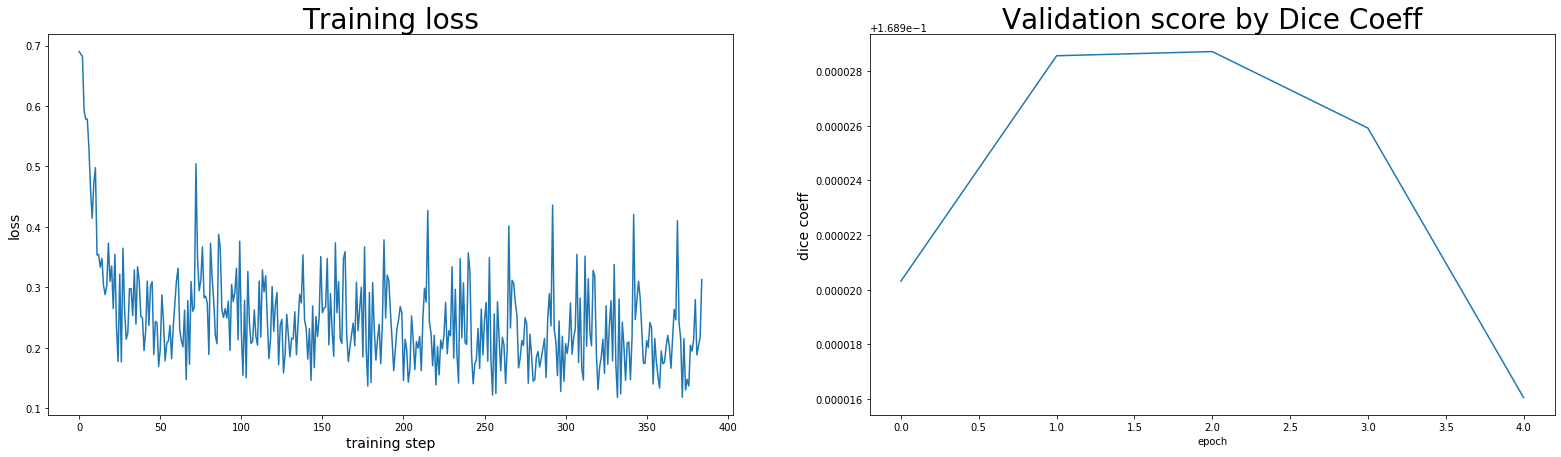

In [61]:
net = UNet(LAYER_LEN)
net = net.cuda() if torch.cuda.is_available() else net.cpu()

optimizer = optim.SGD(
    net.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=0.0005 # L2penalty rate
)

criterion = nn.BCELoss()


train_losses = []
dice_coeffs = []

for epoch in range(1, EPOCH+1):
    if VERBOSE: print("Start epoch:", epoch)

    train = patch_pairs(train_paths)
    val = patch_pairs(val_paths)
    
    # train section
    epoch_loss = 0
    start_time = time.time()
    for i, batch in enumerate(make_batch(train, BATCH_SIZE)):
        
        # load patch data
        mosaic = to_torch(np.array([b[0] for b in batch]).astype(np.float32))
        segm_vec = to_torch(np.array([b[1] for b in batch]))
                        
        # predict and get the loss
        pred = net(mosaic) # (2, 6, 640, 640)
        prob = torch.sigmoid(pred)
        loss = criterion(prob.flatten(), segm_vec.flatten())
        
        # optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record train loss
        epoch_loss += loss.item()
        train_losses.append(loss.item())

        if VERBOSE:
            if i % REPORT_INTERVAL == 0:
                elapsed = time.time() - start_time
                progress = i / (train_len / BATCH_SIZE)
                left_time = "-" if i == 0 else int((elapsed / (progress)) * (1. - progress))
                print("{} / {} trained | loss: {:.4} | epoch time: {} [sec] ({} [sec] left)" \
                      .format(i * BATCH_SIZE, train_len, loss.item(), int(elapsed), left_time))

    if VERBOSE:
        print("Training in epoch {} finished ! Average loss: {:.4} | epoch time: {} [sec]\n" \
              .format(epoch, epoch_loss / train_len, int(time.time() - start_time)))
    
    
    
    # validation section
    val_dice = 0
    for i, val_pair in enumerate(val):
        
        # load validation data
        # unsqueeze to generate batch dimension
        mosaic = to_torch(val_pair[0]).unsqueeze(0) # (1, 3, 640, 640)
        segm_vec = to_torch(val_pair[1])
        
        # gradient calculation is unnecessary for validation
        with torch.no_grad():
            pred = net(mosaic) # (1, 6, 640, 640)
            prob = torch.sigmoid(pred).squeeze(0)
            prob = prob.permute(1, 2, 0)
        
        # calculate dice coefficient:
        one_hot_prob = prob_to_one_hot(prob)
        val_dice += dice_coeff(one_hot_prob, segm_vec)
        
        # report progress
        if VERBOSE:
            if i % REPORT_INTERVAL == 0:
                print(f"validation progress: {i}/{val_len}")
    
    # create checkpoint
    torch.save(net.state_dict(), f"{CHECKPOINT_DIR}cp_{epoch}.pth")
    if VERBOSE: print(f"Checkpoint {epoch} saved !")
    
    # report the result of this epoch
    dice_coeffs.append(val_dice / val_len)
    if VERBOSE: print(f"Validation Dice Coeff Average: {round(np.average(dice_coeffs), 5)}\n")


np.save(f"{HISTORY_DIR}loss", train_losses)
np.save(f"{HISTORY_DIR}dice", dice_coeffs)

# Show the training result by matplotlib graphs
fig = plt.figure(figsize=(27, 7))

ax1 = fig.add_subplot(121)
ax1.plot(train_losses)
ax1.set_title('Training loss', fontsize=28)
ax1.set_xlabel('training step', fontsize=14)
ax1.set_ylabel('loss', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(dice_coeffs)
ax2.set_title('Validation score by Dice Coeff', fontsize=28)
ax2.set_xlabel('epoch')
ax2.set_ylabel('dice coeff', fontsize=14)

plt.show()

Load the last check point parameters

In [16]:
net = UNet(n_classes=LAYER_LEN)
net = net.cuda() if torch.cuda.is_available() else net.cpu()
net.load_state_dict(torch.load(f"{CHECKPOINT_DIR}cp_{EPOCH}.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Validation by the test data

Test for: ../datasets/forests/patches/mosaic/00187_wM1_14-3_640_0_Mosaic.jpg
Test Dice Coefficient: 0.59031


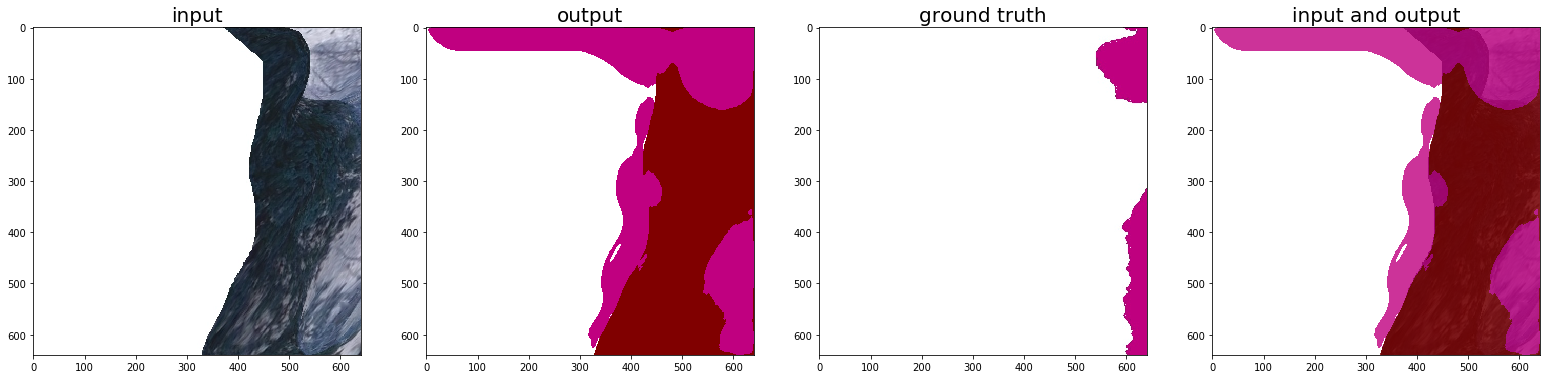

Test for: ../datasets/forests/patches/mosaic/00176_wM1_12-11_640_0_Mosaic.jpg
Test Dice Coefficient: 0.69005


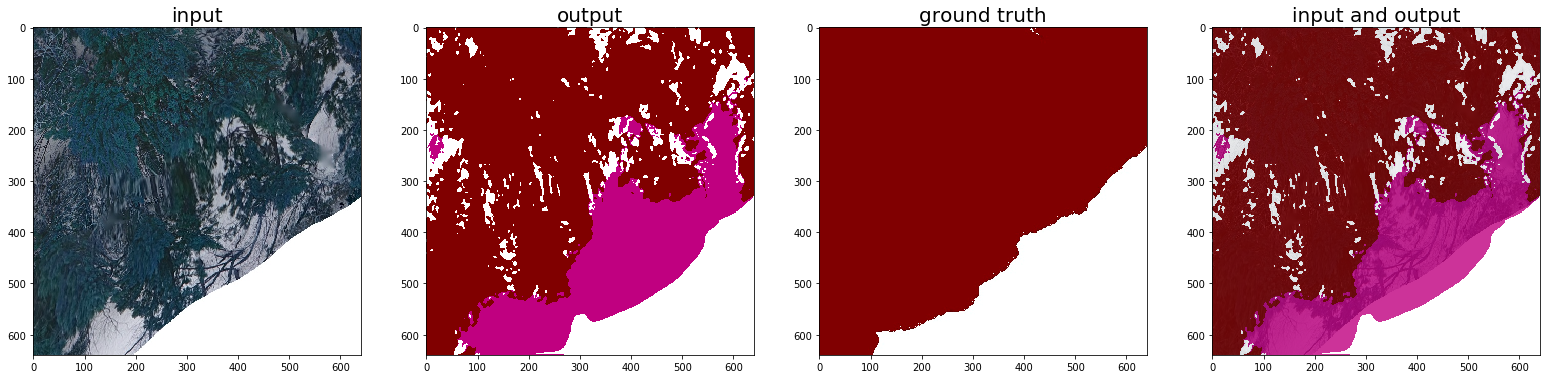

Test for: ../datasets/forests/patches/mosaic/00082_wM1_6-7_640_0_Mosaic.jpg
Test Dice Coefficient: 0.65296


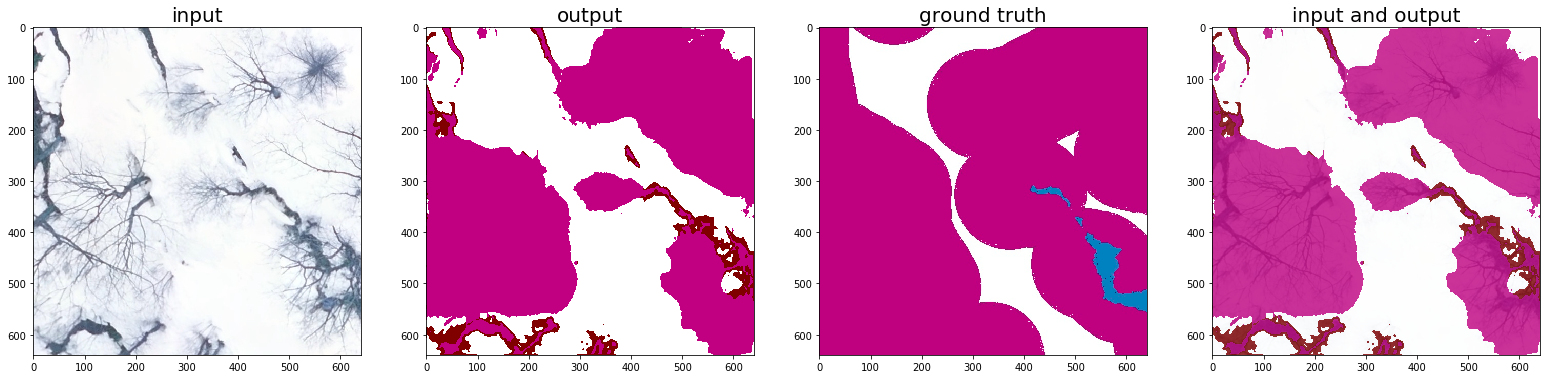

In [63]:
# gradient calculation is unnecessary because this is not training
LIMIT = 3

with torch.no_grad():
    for i, test_path in enumerate(test_paths):

        if i >= LIMIT: break        

        print("Test for:", test_path[0])
        
        test_mosaic = cv2.imread(test_path[0])
        test_segm = cv2.imread(test_path[1])
        test_segm_vec = to_torch(np.load(test_path[2]))
        
        mosaic = np.array(test_mosaic, dtype=np.float32) / 255
        pred = net(to_torch(np.transpose(mosaic, axes=[2, 0, 1])).unsqueeze(0))
        prob = torch.sigmoid(pred).squeeze(0).permute(1, 2, 0)
        pred_segm = prob_to_segm(prob)
        
        one_hot_prob = prob_to_one_hot(prob)
        print("Test Dice Coefficient:", round(dice_coeff(one_hot_prob, test_segm_vec), 5))
        
        # Output the result by matplotlib
        fig = plt.figure(figsize=(27, 7))

        ax1 = fig.add_subplot(141)
        ax1.imshow(test_mosaic)
        ax1.set_title('input', fontsize=20)

        ax2 = fig.add_subplot(142)
        ax2.imshow(pred_segm)
        ax2.set_title('output', fontsize=20)
        
        ax3 = fig.add_subplot(143)
        ax3.imshow(test_segm)
        ax3.set_title('ground truth', fontsize=20)

        ax4 = fig.add_subplot(144)
        ax4.imshow(test_mosaic)
        ax4.imshow(pred_segm, alpha=0.8)
        ax4.set_title('input and output', fontsize=20)
        
        plt.show()

モザイク全体のマスク画像を作成したい